## Import all the libraries

We import all the libraries that are going to be used during the script

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 400
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, norm
import random
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from itertools import product
from tensorflow.keras import backend as K
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import *
from sklearn.utils import class_weight
from tensorflow.keras import metrics
import visualkeras
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

## Set all seeds

We set all seeds to ensure reproductibility of the code.

In [3]:
seed = 42

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Load dataset

We read the dataset from the CSV generated on the previous .ipynb.

In [4]:
file = "https://raw.githubusercontent.com/joaquirori/Using-deep-learning-techniques-to-predict-solar-switchbacks/main/PSP_data.csv"
df = pd.read_csv(file)
df.head()

,date,Br,Bt,Bn,np_fit,wp_fit,vp_fit_R,vp_fit_T,vp_fit_N,na_fit,wa_fit,va_fit_R,va_fit_T,va_fit_N,distance_au,z,switchback
0,2018-11-01 00:00:00,-33.844070,24.559757,-0.491868,124.14915,85.248460,357.76196,-22.141657,1.113809,NaN,NaN,NaN,NaN,NaN,0.2389,NaN,False
1,2018-11-01 00:00:05,-34.260450,24.127703,-3.308359,128.37523,86.012474,351.19450,-26.101020,-7.876099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2018-11-01 00:00:10,-33.469240,25.651606,-4.649886,133.62800,90.273350,353.80860,-24.602808,-13.071443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2018-11-01 00:00:15,-35.103474,22.752834,-6.129280,132.06032,86.126220,348.72855,-30.869125,-17.230963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2018-11-01 00:00:20,-36.270770,20.326946,-8.134771,133.95546,85.230675,345.14322,-33.911213,-23.894878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


## Initial cleaning & type conversion


Firstly, the switchback column is transformed from True/False to numeric for binary classification.

False:0

True: 1

Then, we drop the column z since it is not going to be used as target and can not be used for predicting switchbacks since it would leak future information into the past.

In [5]:
# Convert switchback boolean flags to numerical format for machine learning compatibility
df["switchback"] = df["switchback"].astype(float)

# Remove the continuous z parameter, keeping only the binary switchback classification
df.drop("z", axis=1, inplace=True)

The dataframe content description is displayed in order to check for variables with a high number of NaN values

In [6]:
# Generate descriptive statistics for all numerical columns
df_desc = df.describe().T

# Calculate missing value counts for each float column
n_nan = []
for i in df.select_dtypes("float").columns:
    count = len(df[df[i].isna()])  # Count NaN values in each column
    n_nan.append(count)

# Add missing value statistics to the descriptive summary
df_desc["n_nan"] = n_nan  # Absolute count of missing values
df_desc["%_nan"] = df_desc["n_nan"] / len(df) * 100  # Percentage of missing values

# Display key statistical measures including data completeness
df_desc[["mean", "std", "min", "max", "%_nan"]]

,mean,std,min,max,%_nan
Br,-52.007607,26.633230,-103.671170,83.006840,0.000000
Bt,12.152223,30.239968,-92.915840,108.207810,0.000000
Bn,-0.880478,26.577655,-87.156630,93.856050,0.000000
np_fit,283.678731,121.580079,45.187980,9839.595000,1.530350
wp_fit,77.028829,22.057811,7.964923,284.586060,1.485340
vp_fit_R,335.619710,73.833109,19.765856,729.593800,1.485340
vp_fit_T,19.998993,35.899150,-169.915970,122.804855,1.530350
vp_fit_N,0.206618,40.391591,-219.848510,346.685000,1.530350
na_fit,NaN,NaN,NaN,NaN,100.000000
wa_fit,NaN,NaN,NaN,NaN,100.000000


It can be seen that the alpha particle fits and the distance has a very high percentage of Nan values.

- alpha particles data will be removed from the dataframe
- distance data will be interpolated since it is know that the PSP followed a continuous orbit

## Select relevant features

We create `df_switchback` with the columns used by the model:

- Magnetic field components: `Br`, `Bt`, `Bn`
- Plasma parameters: `np_fit`, `wp_fit`, `vp_fit_R`, `vp_fit_T`, `vp_fit_N`
- Distance: `distance_au`
- Target: `switchback`



In [7]:
# Create a focused dataset with only the relevant features for switchback analysis
df_switchback = df[["Br", "Bt", "Bn", "np_fit", "wp_fit", "vp_fit_R", "vp_fit_T", "vp_fit_N", "distance_au", "switchback"]]
df_switchback

,Br,Bt,Bn,np_fit,wp_fit,vp_fit_R,vp_fit_T,vp_fit_N,distance_au,switchback
0,-33.844070,24.559757,-0.491868,124.149150,85.248460,357.76196,-22.141657,1.113809,0.2389,0.0
1,-34.260450,24.127703,-3.308359,128.375230,86.012474,351.19450,-26.101020,-7.876099,NaN,0.0
2,-33.469240,25.651606,-4.649886,133.628000,90.273350,353.80860,-24.602808,-13.071443,NaN,0.0
3,-35.103474,22.752834,-6.129280,132.060320,86.126220,348.72855,-30.869125,-17.230963,NaN,0.0
4,-36.270770,20.326946,-8.134771,133.955460,85.230675,345.14322,-33.911213,-23.894878,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
155515,-51.887962,12.116952,12.527465,59.910072,84.289670,464.17975,37.831596,41.564037,NaN,0.0
155516,-52.460390,4.130184,15.793304,58.790440,79.318794,460.98172,16.959772,53.144073,NaN,0.0
155517,-53.124960,-4.578252,15.231713,59.154613,74.733055,459.99840,-4.465960,45.284714,NaN,0.0
155518,-52.687485,-0.780584,16.793964,64.689840,81.281550,451.01950,8.400615,48.643850,NaN,0.0


## Missing value imputation (KNN)

We impute missing values in plasma variables (`np_fit`, `wp_fit`, `vp_fit_*`) using a **KNNImputer** with `n_neighbors=10`.  
- Neighbors are identified using the magnetic field columns `Br`, `Bt`, `Bn`.  
- For each target column we fit+transform the 4-column matrix `[Br, Bt, Bn, target]` and then replace only the target column with the imputed values.

In [8]:
# Define feature groups for KNN imputation strategy
distance_cols = ["Br", "Bt", "Bn"]  # Magnetic field components as predictor features
target_cols = ["np_fit", "wp_fit", "vp_fit_R", "vp_fit_T", "vp_fit_N"]  # Plasma parameters to be imputed

# Initialize KNN imputer with 10 nearest neighbors
imputer = KNNImputer(n_neighbors=10)

# Impute missing plasma values using magnetic field data as predictors
for col in target_cols:
    # Create temporary dataset with magnetic field predictors and current plasma target
    temp_data = df_switchback[distance_cols + [col]]
    
    # Use magnetic field similarity to impute missing plasma values
    imputed_array = imputer.fit_transform(temp_data)
    
    # Update only the target plasma parameter with imputed values
    df_switchback[col] = imputed_array[:, -1]

## Interpolate distance_au (irregular sampling)

We create a funtion to fill the nan values in the distance au colum by doing a linear interpolation of the data. This can be done because it is know that the PSP orbit is continuous.

The distance_au gets resampled from a 2 min granularity to a 5 sec granulrity as the rest of the variables.

In [9]:
def interpolate_distance_column(df, distance_column):
    """
    Interpolate distance column that has many nulls due to different granularities
    Uses row index as the basis for interpolation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with distance column containing nulls
    distance_column : str, default 'distance_au'
        Name of the distance column to interpolate
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with interpolated distance values (no more nulls)
    """
    
    # Preserve original data by working on a copy
    df_copy = df.copy()
    
    # Identify rows with valid distance measurements
    mask = df_copy[distance_column].notna()
    valid_indices = df_copy.index[mask].values  # Row positions of non-null values
    valid_distances = df_copy.loc[mask, distance_column].values  # Actual distance values
    
    print(f"Found {len(valid_distances)} non-null distance values out of {len(df_copy)} total rows")
    
    # Ensure sufficient data points for meaningful interpolation
    if len(valid_distances) < 2:
        raise ValueError("Need at least 2 non-null distance values for interpolation")
    
    # Set up linear interpolation based on temporal sequence (row indices)
    interpolator = interp1d(valid_indices, 
                           valid_distances, 
                           kind='linear',
                           bounds_error=False, 
                           fill_value='extrapolate')  # Handle edge cases with extrapolation
    
    # Apply interpolation to fill all missing distance values
    all_indices = df_copy.index.values
    interpolated_distances = interpolator(all_indices)
    
    # Replace original distance column with gap-filled values
    df_copy[distance_column] = interpolated_distances
    
    print(f"Interpolated distance column - no more nulls")
    print(f"Distance range: {interpolated_distances.min():.4f} to {interpolated_distances.max():.4f} AU")
    
    return df_copy

In [10]:
# Apply linear interpolation to fill missing distance measurements
df_switchback = interpolate_distance_column(df_switchback, "distance_au")

Found 6480 non-null distance values out of 155520 total rows
Interpolated distance column - no more nulls
Distance range: 0.1659 to 0.2389 AU


We compute the descriptive statistics of the dataframe again in order to check that it is cleaned and it does not have any other Nan value that could cause problems in the future.

In [11]:
# Generate updated descriptive statistics after imputation and interpolation
df_desc = df_switchback.describe().T

# Verify data completeness after missing value treatment
n_nan = []
for i in df_switchback.select_dtypes("float").columns:
    count = len(df_switchback[df_switchback[i].isna()])  # Count remaining NaN values
    n_nan.append(count)

# Add missing value statistics to confirm successful imputation
df_desc["n_nan"] = n_nan  # Absolute count of remaining missing values
df_desc["%_nan"] = df_desc["n_nan"] / len(df_switchback) * 100  # Percentage of remaining missing values

# Display statistical summary with data completeness metrics
df_desc[["mean", "std", "min", "max", "%_nan"]]

,mean,std,min,max,%_nan
Br,-52.007607,26.633230,-103.671170,83.006840,0.0
Bt,12.152223,30.239968,-92.915840,108.207810,0.0
Bn,-0.880478,26.577655,-87.156630,93.856050,0.0
np_fit,284.112847,120.964477,45.187980,9839.595000,0.0
wp_fit,77.019450,21.963577,7.964923,284.586060,0.0
vp_fit_R,335.546553,73.539227,19.765856,729.593800,0.0
vp_fit_T,20.049815,35.848080,-169.915970,122.804855,0.0
vp_fit_N,0.017710,40.374099,-219.848510,346.685000,0.0
distance_au,0.188475,0.020027,0.165902,0.238900,0.0
switchback,0.026260,0.159909,0.000000,1.000000,0.0


## Chronological train / val / test split

We split the dataset chronologically to respect the time-series nature:

- Training: first 60%
- Validation: next 20%
- Test: final 20%

In [12]:
# Define dataset size for split calculations
n = len(df_switchback)

# Calculate split boundaries for temporal data partitioning
train_end = int(n * 0.6)   # 60% for training
val_end = int(n * 0.80)    # Next 20% for validation (total 80%)

# Create chronological train/validation/test splits to preserve temporal order
df_train = df_switchback.iloc[:train_end]      # First 60% chronologically
df_val = df_switchback.iloc[train_end:val_end] # Middle 20% chronologically  
df_test = df_switchback.iloc[val_end:]         # Last 20% chronologically

## Distribution analysis → Scaler choices

We assess skewness and kurtosis for each variable and decide the scaling approach:
- Variables close to Gaussian (skewness near 0) → `StandardScaler` (mean=0, std=1).
- Non-Gaussian variables (strong skew) → `MinMaxScaler` (keeps monotonic relationships).

The reason for that is that some models are sensitive to variable scale and distribution. Standardizing Gaussian-ish features keeps them centered, while MinMax avoids distorting highly skewed values.


In [41]:
# Create a comprehensive distribution analysis grid for all features
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()

# Generate histograms with statistical analysis for each feature
for i, col in enumerate(df_train.columns[0:-1]):  # Exclude target variable 'switchback'
    data = df_train[col].dropna()

    # Create histogram showing actual data distribution
    counts, bins, _ = axes[i].hist(data, bins=50, alpha=0.6, color="b")

    # Calculate distribution shape metrics
    sk = skew(data)  # Measure of asymmetry
    kt = kurtosis(data, fisher=False)  # Measure of tail heaviness (normal dist = 3)

    # Fit and overlay theoretical Gaussian distribution
    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(np.min(data), np.max(data), 1000)

    # Scale Gaussian curve to match histogram frequency counts
    bin_width = bins[1] - bins[0]
    gaussian_scaled = norm.pdf(x, mu, sigma) * len(data) * bin_width

    axes[i].plot(x, gaussian_scaled, "r-", lw=2)

    # Add informative title and statistical summary
    axes[i].set_title(f"Histogram {col}")
    x_min, x_max = axes[i].get_xlim()
    y_min, y_max = axes[i].get_ylim()

    # Display distribution shape metrics in text box
    axes[i].text(
        x_min + 0.8 * (x_max - x_min),  # Position in upper right
        y_max * 0.85,                   
        f"Skew: {sk:.2f}\nKurt: {kt:.2f}",
        bbox=dict(boxstyle="round", facecolor="white",
                  edgecolor="black", alpha=0.8, pad=0.8),
        fontsize=10,
        ha="left"
    )

    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

If the skewness of a variable is between -0.5 and 0.5, we can consider the data to be approximately symmetric. Likewise, if the kurtosis lies between 2.5 and 3.5, the distribution can be considered close to normal. Therefore, when a variable satisfies both conditions—skewness between -0.5 and 0.5 and kurtosis between 2.5 and 3.5—we can reasonably treat it as Gaussian distributed.

Based on these criteria, the Gaussian distributed variables are: Bt, Bn, vp_fit_T and vp_fit_N. The remaining variables—Br, np_fit, wp_fit, vp_fit_R and distance_au are classified as non-Gaussian.

Accordingly, the Gaussian distributed variables will be transformed using a StandardScaler, while the non-Gaussian variables will be transformed using a MinMaxScaler.

A sum up of the skeness, kurtosis, and the scaler that will be used can be found on Table.

## Feature scaling (fit on train only)

This step applies **StandardScaler** to `std_col` and **MinMaxScaler** to `mm_col`. Important points:
- Scalers are **fitted only on `df_train`** and then used to transform `df_val` and `df_test` to avoid data leakage.
- We copy the frames first and overwrite scaled columns.

In [14]:
# Define feature groups based on their scaling requirements
std_col = ["Bt", "Bn", "vp_fit_T", "vp_fit_N"]  # Features for standardization (zero mean, unit variance)
mm_col = ["Br", "np_fit", "wp_fit", "vp_fit_R", "distance_au"]  # Features for min-max scaling (0-1 range)

# Initialize scalers for different normalization approaches
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

# Create copies to preserve original data during transformation
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

# Apply standardization to selected features (mean=0, std=1)
for col in std_col:
    scaler = StandardScaler()
    scaler.fit(df_train[[col]])  # Learn scaling parameters from training data only
    df_train_scaled[col] = scaler.transform(df_train[[col]])
    df_val_scaled[col] = scaler.transform(df_val[[col]])
    df_test_scaled[col] = scaler.transform(df_test[[col]])

# Apply min-max normalization to selected features (range 0-1)
for col in mm_col:
    scaler = MinMaxScaler()
    scaler.fit(df_train[[col]])  # Learn scaling parameters from training data only
    df_train_scaled[col] = scaler.transform(df_train[[col]])
    df_val_scaled[col] = scaler.transform(df_val[[col]])
    df_test_scaled[col] = scaler.transform(df_test[[col]])

## Build sequences: `timesteps` function

`timesteps(dataframe, steps, target_offset)` converts a DataFrame into supervised sequences which have the proper tensor/matrix form for RNNs:
- `steps` = number of historical time steps (here 12, 1 minute).
- `target_offset` = how far ahead to predict (here 1 → predict the next point of time).

Returns:
- `X`: array shaped `(n_samples, steps, n_features)`
- `Y`: corresponding targets (each is a row/series from the frame at the prediction index)


In [15]:
def timesteps(dataframe, steps, target_offset):
    X = []
    Y = []
    # Create sliding windows across the temporal dataset
    for i in range(len(dataframe) - steps - target_offset + 1):
        # Extract sequence of 'steps' consecutive observations as input features
        x = dataframe.iloc[i : i + steps].values
        # Extract target value at specified offset from end of input sequence
        y = dataframe.iloc[i + steps + target_offset - 1]
        X.append(x)
        Y.append(y)
    # Convert to numpy arrays for model compatibility
    return np.array(X), np.array(Y)

## Select features and target from sequences

After creating sequences, we do:
- We use the first 9 features, that corresponds to magnetic field, proton fits and distance data, as x
- We use the last feature, that corresponds to switchbacks, as y

So each training sample has shape `(12, 9)` — 12 time steps and 9 features — and `y` is a single binary label per sample.

In [16]:
# Create training sequences with 12 timesteps to predict 1 step ahead
x_train, y_train = timesteps(df_train_scaled, 12, 1)
x_train = x_train[0::,0:12,0:9]  # Use all samples, 12 timesteps, first 9 features (exclude target)
y_train = y_train[0::,9:10]      # Extract switchback target (column 9) as labels

# Create validation sequences with same temporal structure
x_val, y_val = timesteps(df_val_scaled, 12, 1)
x_val = x_val[0::,0:12,0:9]      # Use all samples, 12 timesteps, first 9 features
y_val = y_val[0::,9:10]          # Extract switchback target for validation

# Create test sequences with same temporal structure
x_test, y_test = timesteps(df_test_scaled, 12, 1)
x_test = x_test[0::,0:12,0:9]    # Use all samples, 12 timesteps, first 9 features
y_test = y_test[0::,9:10]        # Extract switchback target for final evaluation      

# Class balance & class weights

We print the percentage of positive (`1`) cases in training and validation.

In [17]:
# Check the % of positive labels on training and validation sets
print(f"The percentage of 1 on y_train is: {pd.DataFrame(y_train).value_counts()[1] / len(y_train) * 100}%")
print(f"The percentage of 1 on y_val is: {pd.DataFrame(y_val).value_counts()[1] / len(y_val) * 100}%")

The percentage of 1 on y_train is: 2.712754555198285%
The percentage of 1 on y_val is: 2.89463527595523%


Since the dataset is highly imbalanced, we use a `class_weight` technique. These weights compensate during training so the loss penalizes mistakes on the minority class more heavily.

In [18]:
# Calculate class weights to handle imbalanced switchback dataset
weight0 = len(y_train) / (2 * len(y_train[y_train==0]))  # Weight for non-switchback events (class 0)
weight1 = len(y_train) / (2 * len(y_train[y_train==1]))  # Weight for switchback events (class 1)
print(weight0, weight1)

0.5139419845982659 18.431450019755037


The next thing that is done is creating a function that allows us to create RNN type models quickly with different number of layers, neurons per layer, dropout rates, activation functions, etc.

In [19]:
def RNN_builder(num_layers, layer_type, num_neurons, activation_function, dropout, opt):
    """
    Build a customizable RNN model for switchback detection in solar wind data.
    
    Creates a sequential RNN architecture with configurable layers, neurons, and regularization
    for binary classification of magnetic switchback events from time series data.
    
    Parameters:
    -----------
    num_layers : int
        Number of recurrent layers in the network
    layer_type : keras.layers
        Type of recurrent layer (e.g., LSTM, GRU, SimpleRNN)
    num_neurons : list of int
        Number of neurons for each layer (must match num_layers length)
    activation_function : str
        Activation function for recurrent layers (e.g., 'tanh', 'relu')
    dropout : float
        Dropout rate for regularization (0.0 to 1.0)
    opt : keras.optimizers
        Optimizer for training (e.g., Adam, RMSprop)
        
    Returns:
    --------
    keras.Sequential
        Compiled RNN model ready for training on (12, 9) input sequences
        
    Raises:
    -------
    ValueError
        If length of num_neurons doesn't match num_layers
    """
    # Validate input parameters for consistent architecture specification
    if len(num_neurons) != num_layers:
        raise ValueError(f"Length of num_neurons ({len(num_neurons)}) must equal num_layers ({num_layers})")
    
    # Initialize sequential model for time series classification
    model = keras.Sequential()
    model.add(Input(shape=(12,9)))  # Input: 12 timesteps, 9 features per timestep
    
    # Add recurrent layers with return_sequences=True for intermediate layers
    for i in range(0, num_layers-1):
        model.add(layer_type(num_neurons[i], activation=activation_function, return_sequences=True))
        model.add(Dropout(dropout))  # Regularization to prevent overfitting
    
    # Final recurrent layer outputs single vector (return_sequences=False)
    model.add(layer_type(num_neurons[-1], activation=activation_function, return_sequences=False))
    
    # Binary classification output layer for switchback detection
    model.add(Dense(1, activation="sigmoid"))

    # Configure model for binary classification with comprehensive metrics
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[
            metrics.Precision(name="precision"),  # True positives / (True positives + False positives)
            metrics.Recall(name="recall"),        # True positives / (True positives + False negatives)
            metrics.AUC(name="auc")              # Area under ROC curve
        ]
    )
    return model

## Hyperparameter search with stability evaluation

`hyperparameter_search`:
- Iterates over the parameter grid.
- Trains each candidate model once on the entire training set (historical time series).
- Splits the validation set into `n_cv_splits` chronological chunks and evaluates F1 on each chunk to measure *stability over time* (mean and std of F1).
- Returns a DataFrame with results and the best params by mean F1.

Why this matters: a model whose validation F1 is stable across time chunks is more robust for time-series forecasting in changing conditions.


In [20]:
def hyperparameter_search(param_grid, X_train, y_train, X_val, y_val,
                           model_builder_func, n_cv_splits=1, epochs=15,
                           batch_size=32, verbose=0, early_stopping_patience=5):
    """
    Hyperparameter search with stability evaluation on validation chunks.
    
    Train model ONCE per parameter set (on full training data), then
    evaluate stability across time-split validation chunks.
    
    Parameters
    ----------
    param_grid : dict
        Hyperparameter grid to search.
    X_train, y_train : np.ndarray
        Training data (used fully for model training).
    X_val, y_val : np.ndarray
        Validation data (split into n_cv_splits for evaluation).
    model_builder_func : callable
        Function that builds and compiles a Keras model.
    n_cv_splits : int
        Number of validation chunks for stability testing.
    epochs : int
        Training epochs.
    batch_size : int
        Batch size for training.
    verbose : int
        Verbosity for model.fit().
    early_stopping_patience : int
        Patience for early stopping based on F1 score.
    
    Returns
    -------
    results_df : pd.DataFrame
        Grid search results (params, mean/std F1, chunk-wise scores).
    best_params : dict
        Best hyperparameter set based on mean F1.
    """
    
    # Partition validation data into temporal chunks for stability assessment
    val_size = len(X_val)
    chunk_size = val_size // n_cv_splits
    chunks = []
    for i in range(n_cv_splits):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_cv_splits - 1 else val_size
        chunks.append((start, end))
    
    print(f"Validation set split into {n_cv_splits} chunks of size ~{chunk_size}")
    
    # Generate all hyperparameter combinations from grid
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = list(product(*values))
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    results = []
    
    # Evaluate each hyperparameter combination
    for combo_idx, combination in enumerate(param_combinations):
        params = dict(zip(keys, combination))
        print(f"\nTraining model for combination {combo_idx + 1}/{len(param_combinations)}: {params}")
        
        # Clean up memory from previous model iteration
        K.clear_session()
        
        # Train model on complete training dataset with class balancing
        class_weights = {
            0: weight0,
            1: weight1
        }
        model = model_builder_func(**params)
        
        # Configure early stopping based on F1 score monitoring
        f1_cb = F1Callback((X_val, y_val))
        early_stop = EarlyStopping(
            monitor='val_f1', 
            mode='max', 
            patience=early_stopping_patience, 
            restore_best_weights=True,
            verbose=1 if verbose > 0 else 0
        )
        
        # Execute training with early stopping and class weighting
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=[f1_cb, early_stop],
            verbose=verbose
        )
        
        # Track actual training duration for analysis
        actual_epochs = len(history.history['loss'])
        print(f"  Training stopped at epoch {actual_epochs}/{epochs}")
        
        # Assess model stability across temporal validation chunks
        f1_scores = []
        for i, (start, end) in enumerate(chunks):
            X_chunk, y_chunk = X_val[start:end], y_val[start:end]
            y_pred = (model.predict(X_chunk, verbose=0) > 0.5).astype(int).flatten()
            score = f1_score(y_chunk, y_pred)
            f1_scores.append(score)
        
        # Calculate performance stability metrics
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        
        # Store comprehensive results for this parameter combination
        results.append({
            'param_combo_id': combo_idx,
            'params': params.copy(),
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'chunk_f1_scores': f1_scores,
            'actual_epochs': actual_epochs,
            'best_val_f1': max(history.history.get('val_f1', [0]))
        })
        
        print(f"  Mean F1: {mean_f1:.4f} ± {std_f1:.4f}")
        print(f"  Best validation F1 during training: {max(history.history.get('val_f1', [0])):.4f}")
    
    # Compile results and identify optimal hyperparameters
    results_df = pd.DataFrame(results)
    
    # Select best configuration based on mean F1 performance
    best_idx = results_df['mean_f1'].idxmax()
    best_params = results_df.loc[best_idx, 'params']
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best mean F1: {results_df.loc[best_idx, 'mean_f1']:.4f} ± {results_df.loc[best_idx, 'std_f1']:.4f}")
    
    return results_df, best_params

## F1Callback & hyperparameter grid

- `F1Callback` computes F1 on the held-out validation set at the end of every epoch and stores it in `logs['val_f1']`. This permits early stopping based on `val_f1`.
- The grid defines layer counts, neuron sizes, dropout values and optimizer choices to explore. Keep the grid small for quick prototyping and expand later for final tuning.


In [21]:
class F1Callback(Callback):
    def __init__(self, val_data):
        super().__init__()
        # Store validation data for F1 score computation during training
        self.x_val, self.y_val = val_data
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        # Generate binary predictions using 0.5 threshold for switchback classification
        y_pred = (self.model.predict(self.x_val) > 0.5).astype(int)
        # Calculate F1 score to balance precision and recall for imbalanced dataset
        f1 = f1_score(self.y_val, y_pred)
        # Add F1 metric to logs for early stopping monitoring
        logs['val_f1'] = f1
        print(f" — val_f1: {f1:.4f}")

# Build best model and train

We instantiate the best architecture (example shown: GRU with `[128, 64]`), print `model.summary()`, then train:

- Uses `F1Callback` to compute `val_f1` each epoch.
- `EarlyStopping` monitors `val_f1` and restores best weights.
- `class_weight` compensates for label imbalance.
- `epochs=50` with early stopping typically stops earlier when `val_f1` plateau

In [22]:
# Define hyperparameter search space for 2-layer RNN architectures
grid = {
    "num_layers": [2],  # Fixed at 2 layers for this search
    "layer_type": [LSTM, GRU],  # Compare LSTM vs GRU cell types
    "num_neurons": [
        [32, 16],   # Small architecture: 32→16 neurons
        [64, 32],   # Medium-small: 64→32 neurons  
        [128, 64],  # Medium-large: 128→64 neurons
        [256, 128]  # Large architecture: 256→128 neurons
    ],
    "activation_function": ["tanh"],  # Standard activation for RNNs
    "dropout": [0.1, 0.2],  # Test light vs moderate regularization
    "opt": ["adam"]  # Use Adam optimizer
}

# Execute comprehensive hyperparameter search with temporal validation splits
results_2layers_df, best_params_2layers = hyperparameter_search(
    X_train=x_train, y_train=y_train, 
    X_val=x_val, y_val=y_val, 
    model_builder_func=RNN_builder, 
    param_grid=grid, 
    n_cv_splits=2  # Split validation into 2 temporal chunks for stability assessment
)

Validation set split into 2 chunks of size ~15546
Testing 16 parameter combinations...

Training model for combination 1/16: {'num_layers': 2, 'layer_type': <class 'keras.src.layers.rnn.lstm.LSTM'>, 'num_neurons': [32, 16], 'activation_function': 'tanh', 'dropout': 0.1, 'opt': 'adam'}
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step
 — val_f1: 0.4214
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step
 — val_f1: 0.5201
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step
 — val_f1: 0.4828
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step
 — val_f1: 0.4926
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step
 — val_f1: 0.5071
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step
 — val_f1: 0.5632
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step
 — val_f1: 0.5156
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step
 — val_f1: 0.5235
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step
 — val_f1: 0.5696
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step
 — val_f1: 0.4476
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step
 — val_f1: 0.5688
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step


In [23]:
# Define hyperparameter search space for 3-layer RNN architectures
grid = {
    "num_layers": [3],  # Fixed at 3 layers for deeper network evaluation
    "layer_type": [LSTM, GRU],  # Compare LSTM vs GRU cell types
    "num_neurons": [
        [64, 32, 16],    # Small 3-layer: 64→32→16 neurons
        [128, 64, 32],   # Medium 3-layer: 128→64→32 neurons
        [256, 128, 64]   # Large 3-layer: 256→128→64 neurons
    ],
    "activation_function": ["tanh"],  # Standard activation for RNNs
    "dropout": [0.1, 0.2],  # Test light vs moderate regularization
    "opt": ["adam"]  # Use Adam optimizer
}

# Execute hyperparameter search for deeper 3-layer architectures
results_3layers_df, best_params_3layers = hyperparameter_search(
    X_train=x_train, y_train=y_train, 
    X_val=x_val, y_val=y_val, 
    model_builder_func=RNN_builder, 
    param_grid=grid, 
    n_cv_splits=2  # Split validation into 2 temporal chunks for stability assessment
)

Validation set split into 2 chunks of size ~15546
Testing 12 parameter combinations...

Training model for combination 1/12: {'num_layers': 3, 'layer_type': <class 'keras.src.layers.rnn.lstm.LSTM'>, 'num_neurons': [64, 32, 16], 'activation_function': 'tanh', 'dropout': 0.1, 'opt': 'adam'}
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
 — val_f1: 0.4755
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step
 — val_f1: 0.5307
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step
 — val_f1: 0.4677
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step
 — val_f1: 0.5113
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step
 — val_f1: 0.5026
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step
 — val_f1: 0.4971
972/972 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
 — val_f1: 0.5275
  Training stopped at epoch 7/15
  Mean F1: 0.5411 ± 0.0883
  Best validation F1 during training: 0.5307

Training model for combination 2/12: {'num_layers': 3, 'layer_type': <class 'keras.src.layers.rnn.lstm.LSTM'>, 'num_neurons': [64, 32, 16], 'activation_function': 'tanh', 'dropout

## Models stability analysis

The results from the f1_score of all the combinations of 2 layer and 3 layers models are saved and the results of the 5 models with the highest f1_score are plotted as a boxplot to compare their stability

In [24]:
results_df = pd.concat([results_2layers_df, results_3layers_df])

In [25]:
results_df = results_df.sort_values("mean_f1", ascending=False).head(5)
results_df

,param_combo_id,params,mean_f1,std_f1,chunk_f1_scores,actual_epochs,best_val_f1
10,10,"{'num_layers': 3, 'layer_type': <class 'keras....",0.666342,0.067177,"[0.7335190343546889, 0.5991649269311065]",15,0.670270
6,6,"{'num_layers': 3, 'layer_type': <class 'keras....",0.649270,0.081764,"[0.7310344827586207, 0.5675057208237986]",10,0.644274
12,12,"{'num_layers': 2, 'layer_type': <class 'keras....",0.642932,0.090693,"[0.7336244541484717, 0.5522388059701493]",9,0.635815
13,13,"{'num_layers': 2, 'layer_type': <class 'keras....",0.640092,0.086694,"[0.7267857142857143, 0.5533980582524272]",15,0.635823
15,15,"{'num_layers': 2, 'layer_type': <class 'keras....",0.631608,0.074989,"[0.7065972222222222, 0.5566188197767146]",15,0.628429


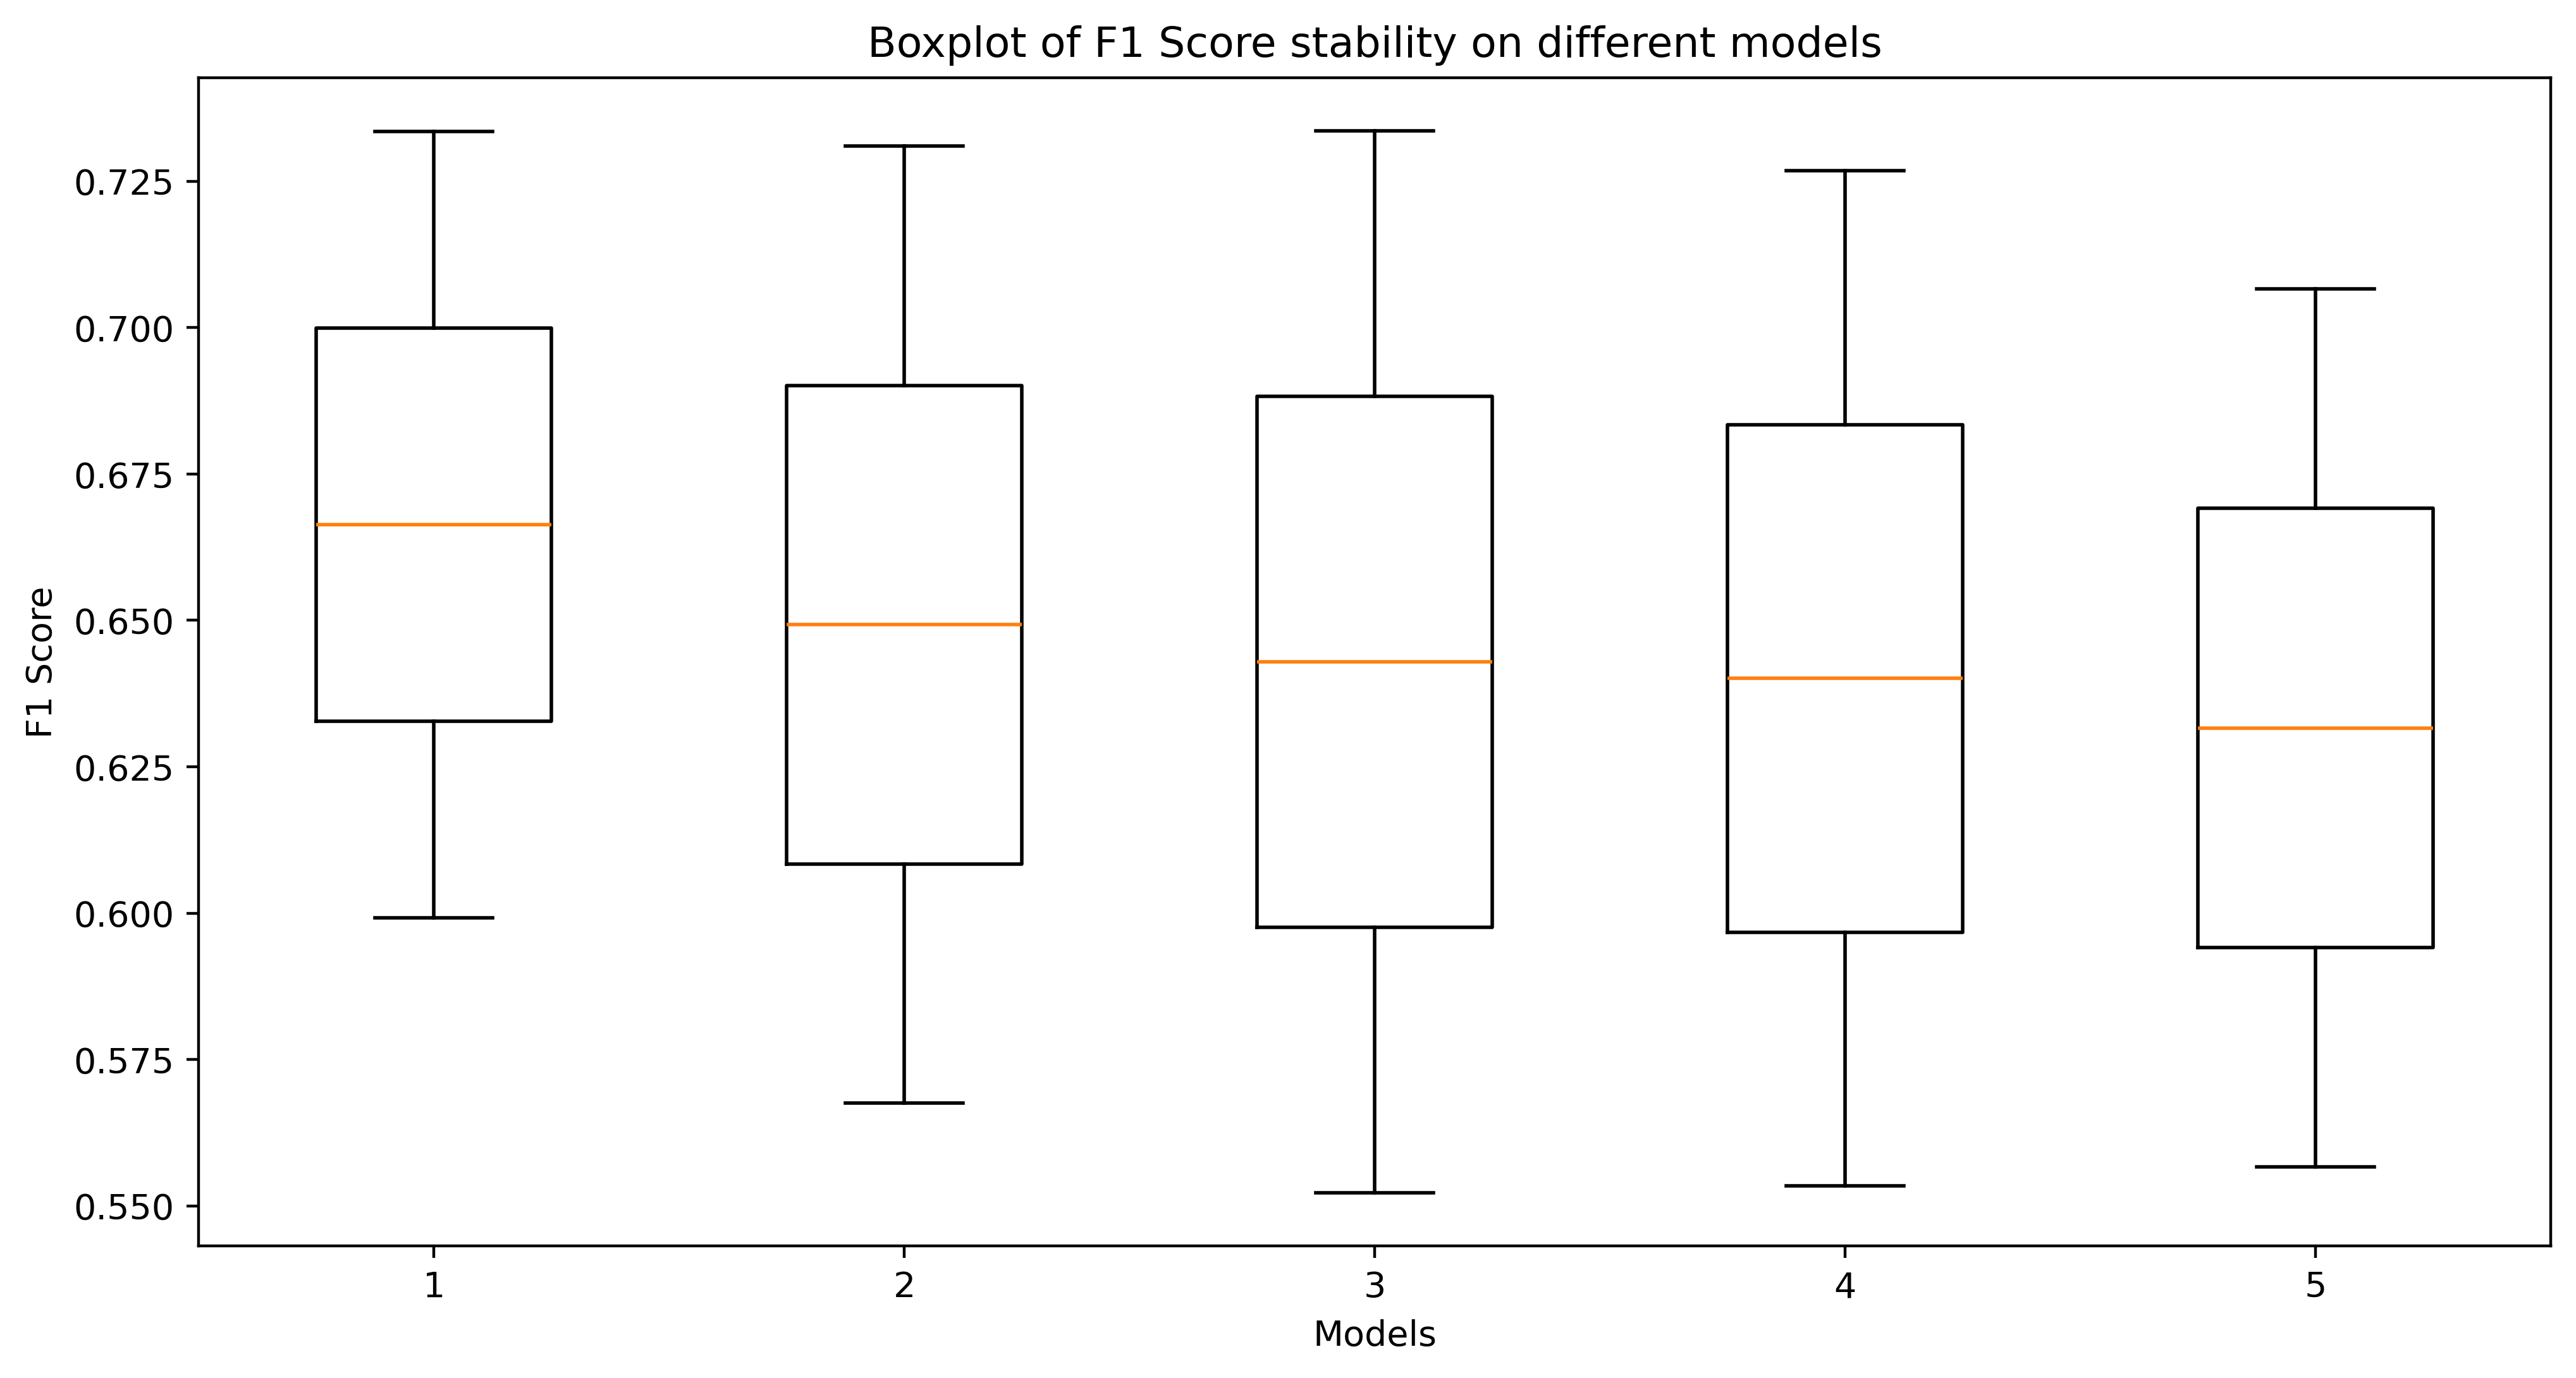

In [42]:
# Visualize F1 score stability across the top 5 hyperparameter configurations
plt.figure(figsize=(12,6))
plt.boxplot(results_df["chunk_f1_scores"])  # Show distribution of F1 scores across temporal validation chunks
plt.title("Boxplot of F1 Score stability on different models")
plt.xlabel("Models")  # Each box represents a different hyperparameter combination
plt.ylabel("F1 Score")  # F1 scores from temporal validation chunks
plt.show()

In [27]:
best_params_2layers

{'num_layers': 2,
 'layer_type': keras.src.layers.rnn.gru.GRU,
 'num_neurons': [128, 64],
 'activation_function': 'tanh',
 'dropout': 0.1,
 'opt': 'adam'}

In [28]:
best_params_3layers

{'num_layers': 3,
 'layer_type': keras.src.layers.rnn.gru.GRU,
 'num_neurons': [256, 128, 64],
 'activation_function': 'tanh',
 'dropout': 0.1,
 'opt': 'adam'}

## Best model retraining

The best and most stable model was created again and it was retrain with all the validation data at once, without using cross validation

In [29]:
# Build final RNN model using optimal hyperparameters from grid search
model = RNN_builder(num_layers=3, layer_type=GRU, num_neurons=[256, 128, 64], activation_function="tanh", opt="adam", dropout=0.1)

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 12, 256)        │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 12, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,593 (1.49 MB)

 Trainable params: 390,593 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Configure custom F1 score tracking for validation monitoring
f1_cb = F1Callback((x_val, y_val))

# Set up early stopping to prevent overfitting based on F1 score performance
early_stop = EarlyStopping(monitor='val_f1', mode='max', patience=10, restore_best_weights=True)

# Apply class weights to handle imbalanced switchback dataset
class_weight = {
    0: weight0,  # Weight for non-switchback events
    1: weight1   # Weight for switchback events
}

# Train the final model with comprehensive monitoring and regularization
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[f1_cb, early_stop],  # Monitor F1 and stop early if no improvement
    class_weight=class_weight       # Balance training for minority class
)

Epoch 1/50
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
 — val_f1: 0.4449
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - auc: 0.9153 - loss: 0.3391 - precision: 0.1390 - recall: 0.8703 - val_auc: 0.9730 - val_loss: 0.1553 - val_precision: 0.2919 - val_recall: 0.9344 - val_f1: 0.4449
Epoch 2/50
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
 — val_f1: 0.5004
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - auc: 0.9734 - loss: 0.1951 - precision: 0.2256 - recall: 0.9534 - val_auc: 0.9848 - val_loss: 0.1384 - val_precision: 0.3408 - val_recall: 0.9411 - val_f1: 0.5004
Epoch 3/50
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
 — val_f1: 0.4900
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - auc: 0.9792 - loss: 0.1694 - precision: 0.2415 - recall: 0.9581 - val_auc: 0.9815 - val_loss: 0.1479 - val_precision: 0.3332 - val_recall: 0.9256 - val_f1: 0.4900
Epoch 4/50
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
 — val_f1: 0.5704
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - auc: 0.9808 - loss: 0.1635 - precision: 0.2

## Probability threshold tuning (choose z)

Neural nets output probabilities. We sweep thresholds from 0.00 to 1.00 (step 0.02) to compute F1 vs threshold on both train and validation sets. The chosen threshold (e.g., **0.61**) is where validation F1 is maximized and provides a better trade-off than the default 0.5 for this imbalanced problem.

Why: optimizing threshold for F1 can substantially improve downstream binary decisions when positives are rare.


In [32]:
# Optimize decision threshold by testing F1 scores across probability thresholds
f1_results_train = []
for i in np.arange(0, 1.01, 0.02):  # Test thresholds from 0.0 to 1.0 in 0.02 increments
    y_pred_train = (model.predict(x_train) > i).astype("int")  # Apply threshold to convert probabilities to binary predictions
    f1 = f1_score(y_train, y_pred_train)  # Calculate F1 score for current threshold
    f1_results_train.append(f1)

2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 1

In [33]:
# Evaluate threshold optimization on validation set to prevent overfitting
f1_results_val = []
for i in np.arange(0, 1.01, 0.02):  # Test same threshold range on validation data
    y_pred_val = (model.predict(x_val) > i).astype("int")  # Apply threshold to validation predictions
    f1 = f1_score(y_val, y_pred_val)  # Calculate validation F1 score for current threshold
    f1_results_val.append(f1)

972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
972/972 ━━━━━━━━

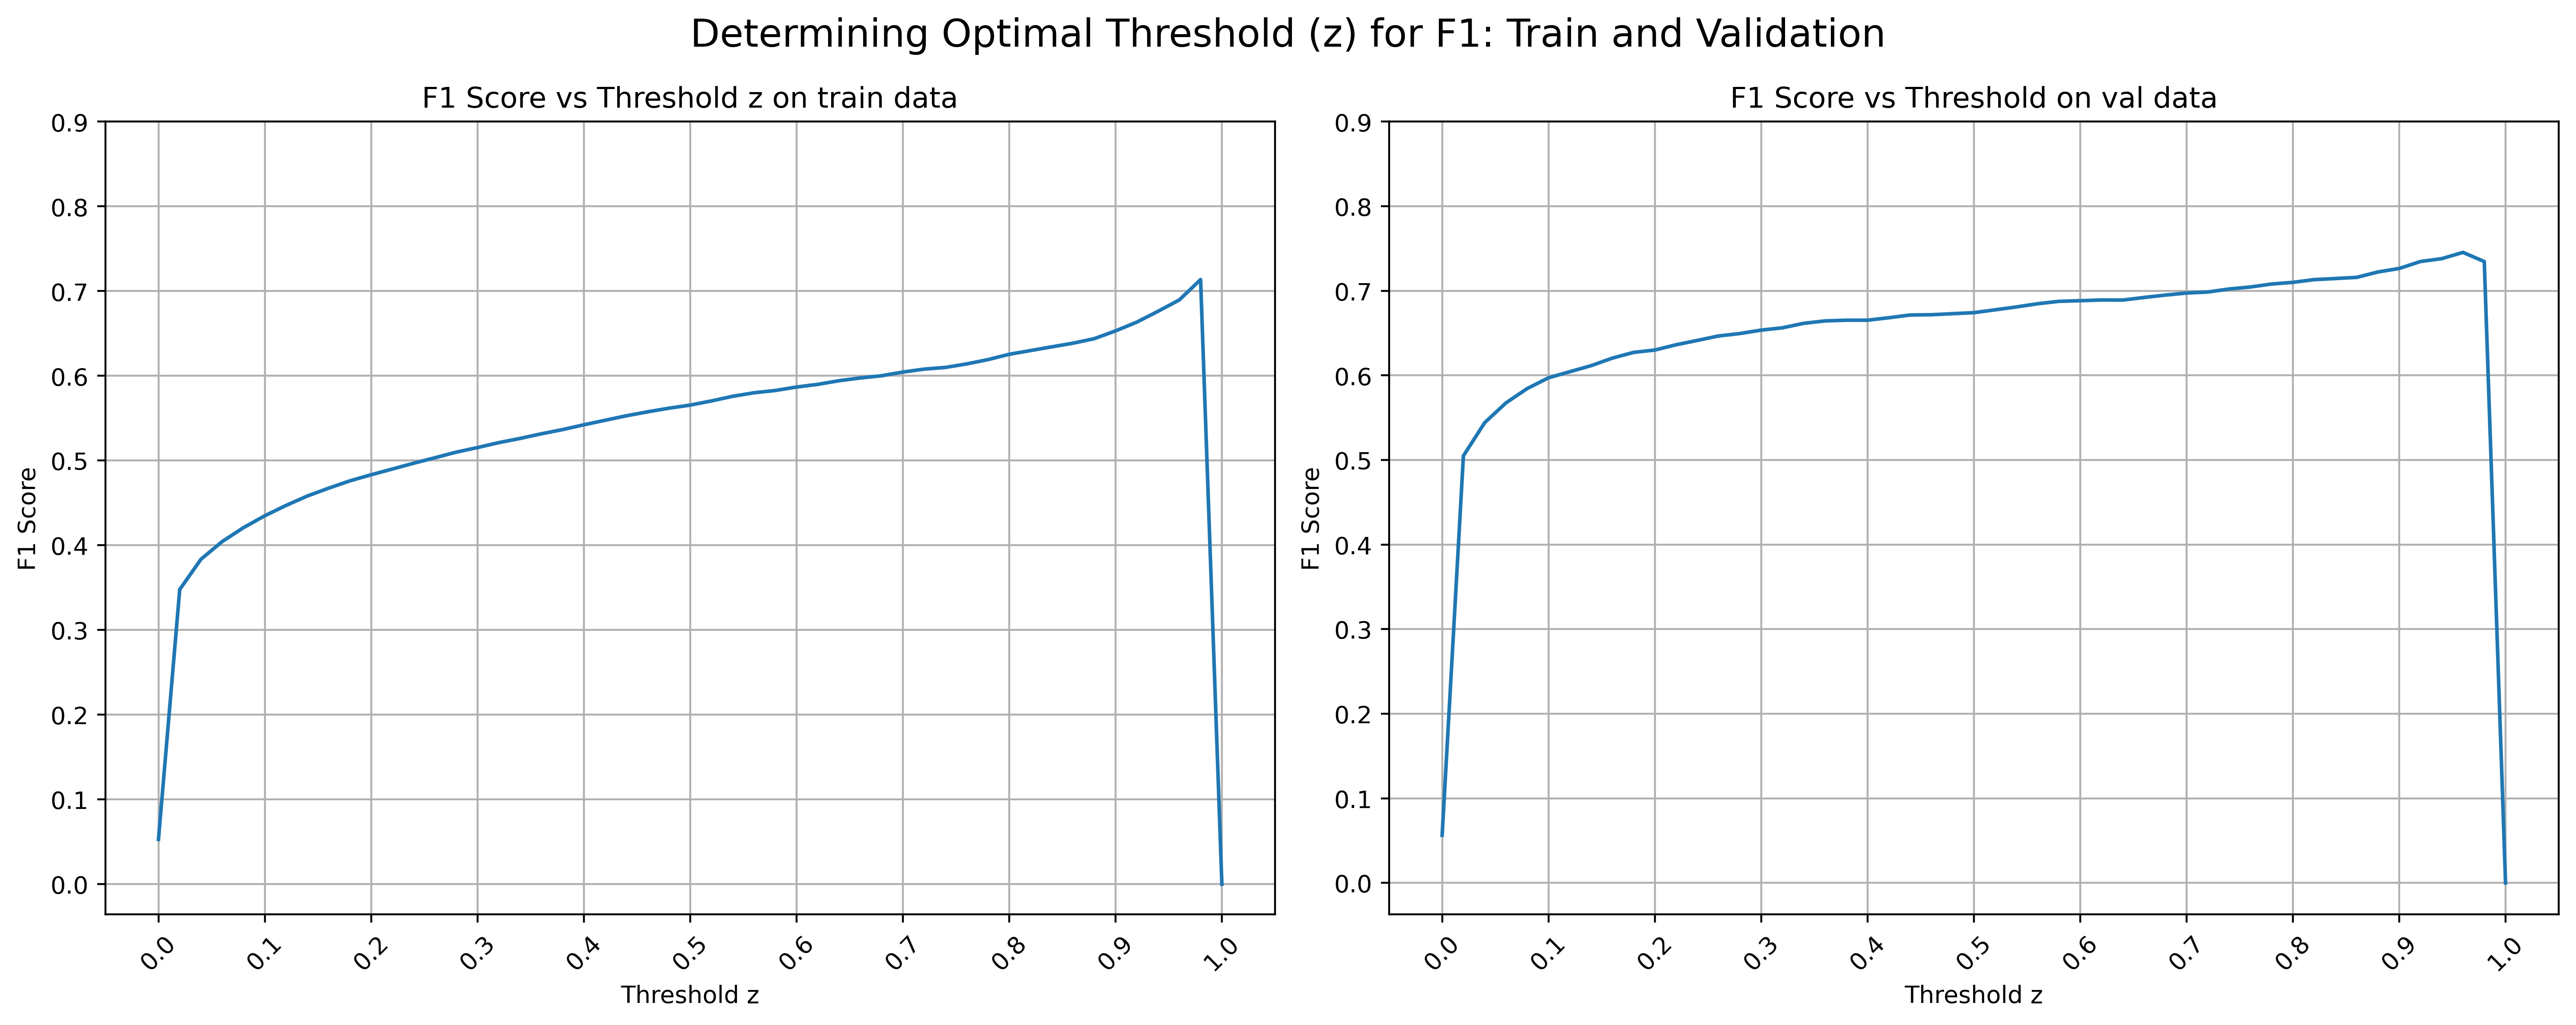

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))  # 1 row, 2 columns of plots
# Train plot
ax[0].plot(np.arange(0, 1.01, 0.02), f1_results_train)
ax[0].set_title("F1 Score vs Threshold z on train data")
ax[0].set_xlabel("Threshold z")
ax[0].set_ylabel("F1 Score")
ax[0].set_xticks(np.arange(0, 1.01, 0.1))  # show ticks every 0.1
ax[0].tick_params(axis='x', rotation=45)   # rotate labels for readability
ax[0].set_yticks(np.arange(0, 1, 0.1))     # show ticks every 0.1
ax[0].grid()
# Validation plot
ax[1].plot(np.arange(0, 1.01, 0.02), f1_results_val)
ax[1].set_title("F1 Score vs Threshold on val data")
ax[1].set_xlabel("Threshold z")
ax[1].set_ylabel("F1 Score")
ax[1].set_xticks(np.arange(0, 1.01, 0.1))
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_yticks(np.arange(0, 1, 0.1))
ax[1].grid()
fig.suptitle("Determining Optimal Threshold (z) for F1: Train and Validation", fontsize=16)
plt.tight_layout()  # prevent overlap with suptitle
plt.show()


## Result analysis

The following metrics of the model are calculated using the test data:
- accuracy
- precision
- recall
- f1 score

In [44]:
# Apply threshold 0.61 to predicted probabilities and convert to integer labels
y_pred_test = (model.predict(x_test) > 0.94).astype("int")

# Evaluate model with different metrics
print(f"The accuracy of the model is: {accuracy_score(y_test, y_pred_test)}")
print(f"The precision of the model is: {precision_score(y_test, y_pred_test)}")
print(f"The recall of the model is: {recall_score(y_test, y_pred_test)}")
print(f"The f1_score of the model is: {f1_score(y_test, y_pred_test)}")

972/972 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
The accuracy of the model is: 0.979930528753377
The precision of the model is: 0.5233494363929146
The recall of the model is: 0.49770290964777947
The f1_score of the model is: 0.5102040816326531


A confusion matrix is plotted to see the number of real positives and negatives and the number of fake positives and negatives.

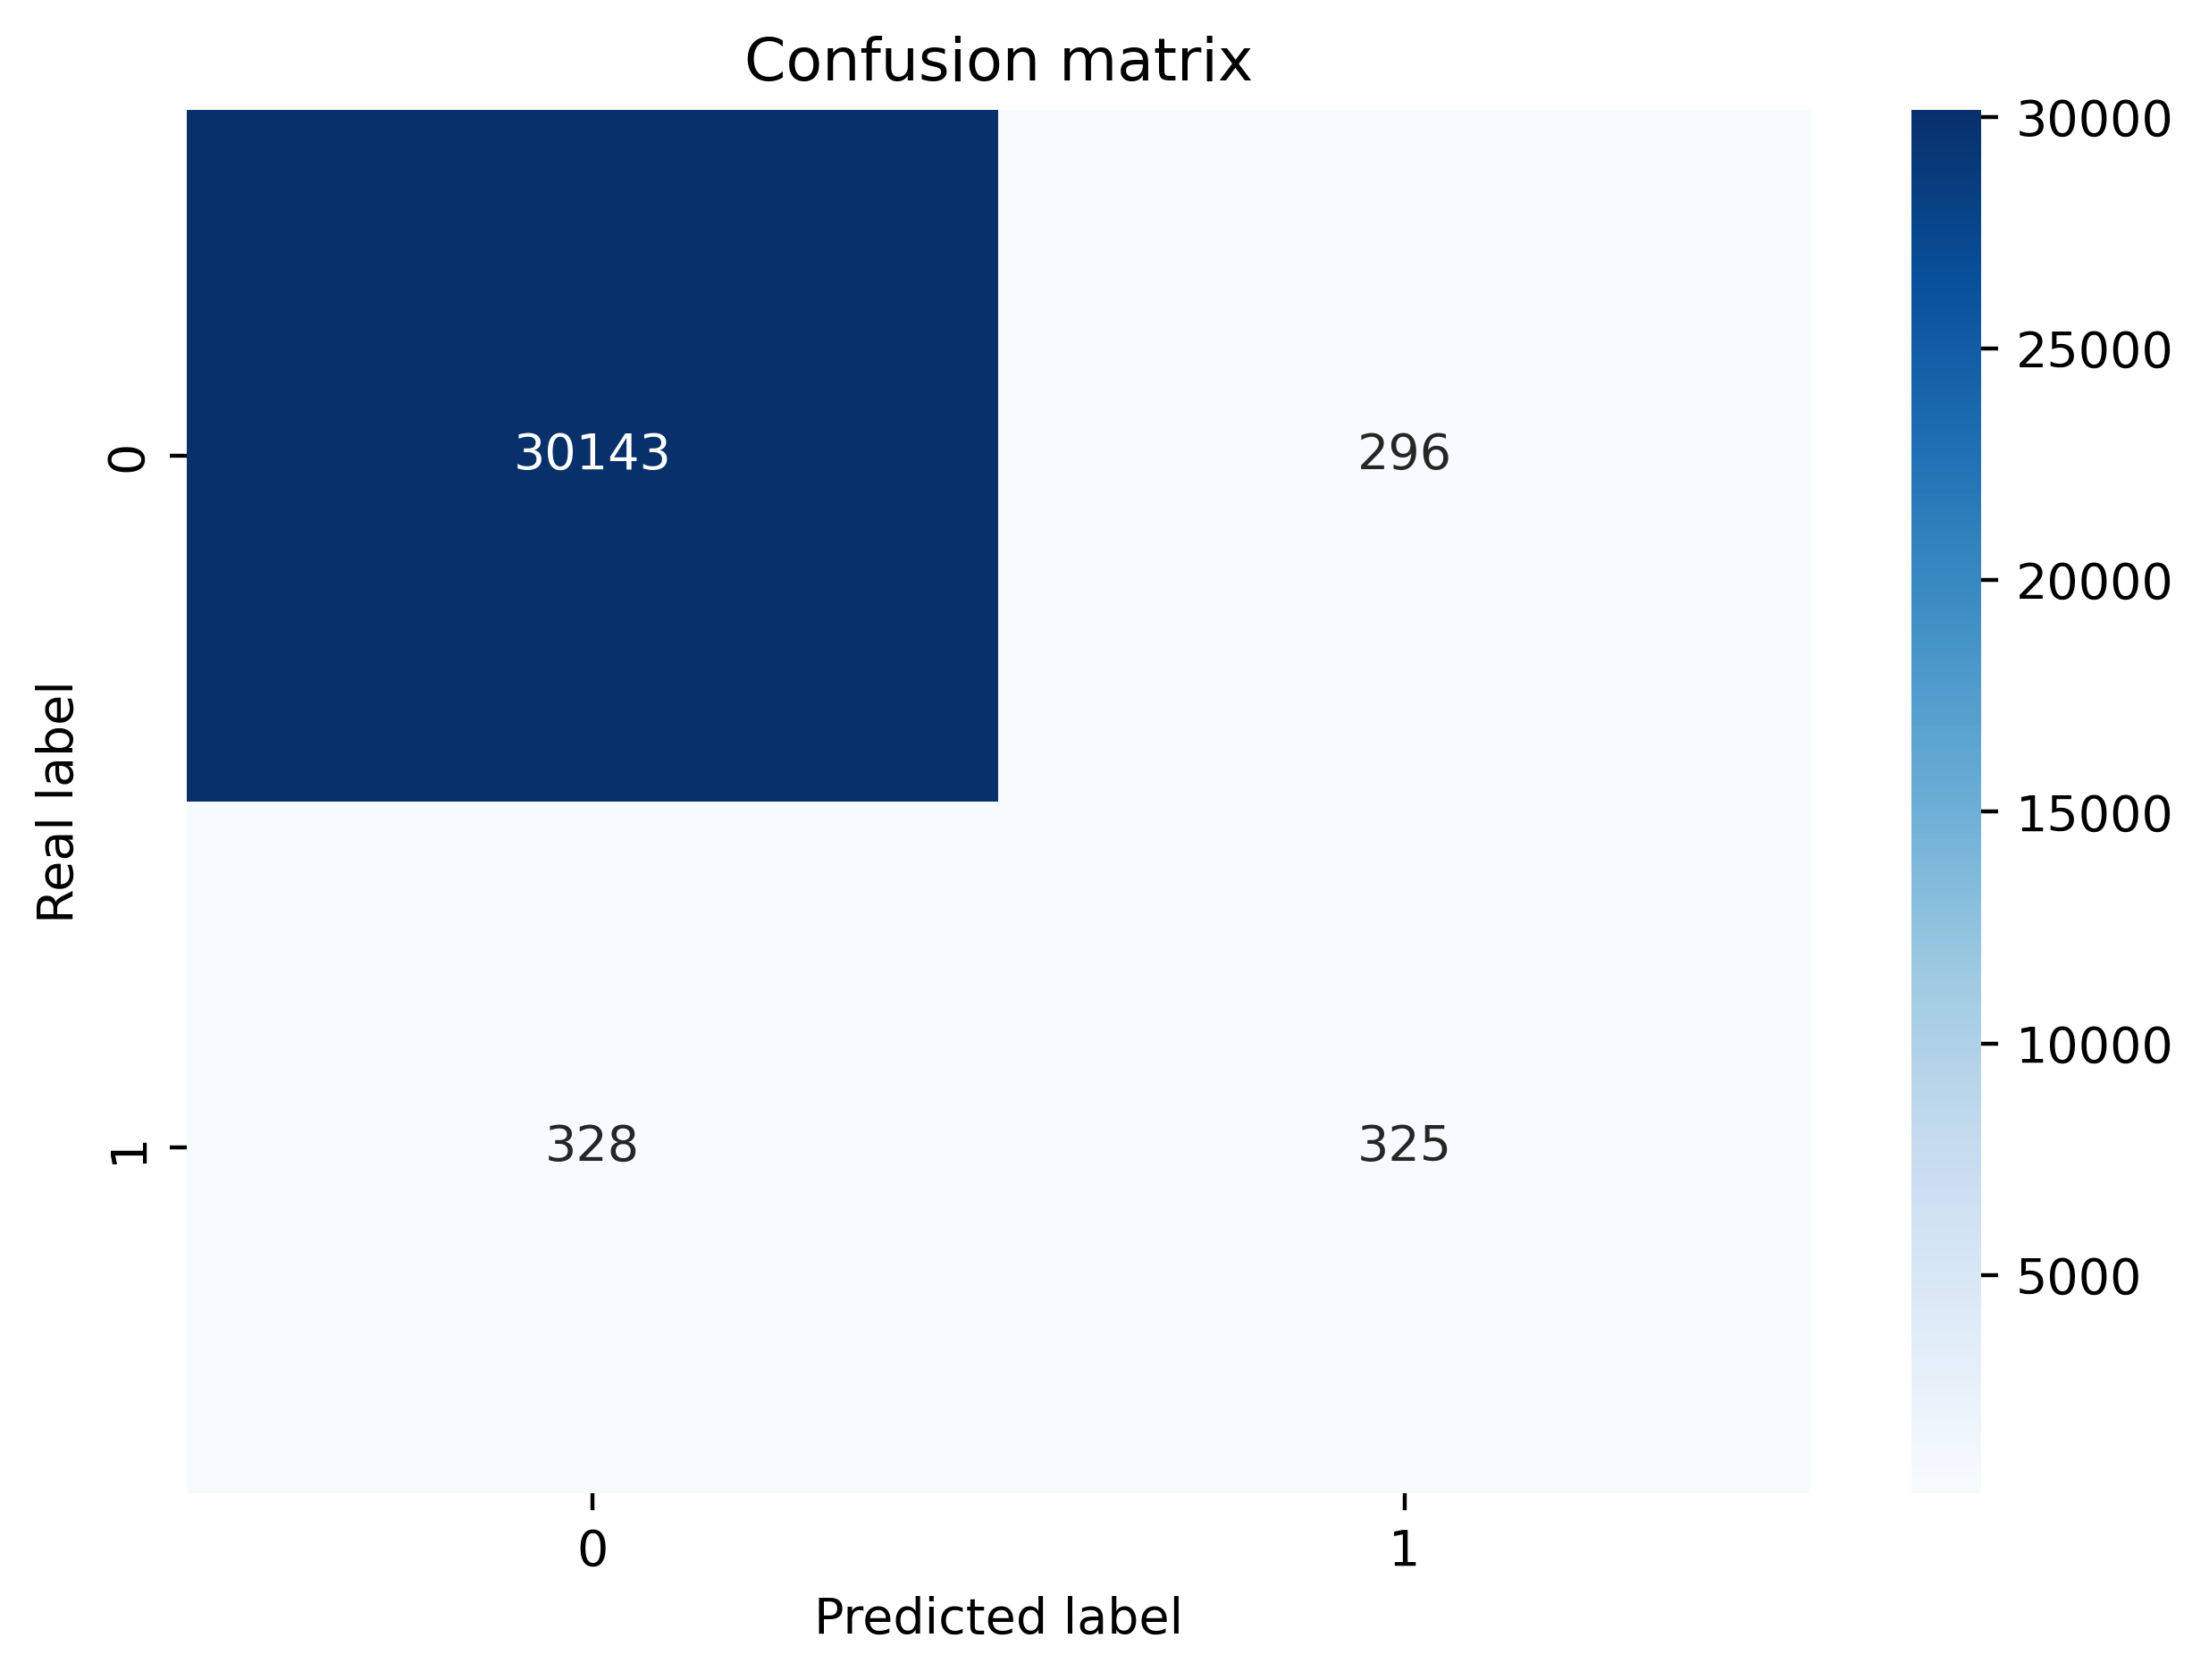

In [45]:
# Heatmap of the confusion matrix (values annotated, blue color scale)
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test), cmap="Blues", annot=True, fmt=".0f")
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("Real label")
plt.tight_layout()  # adjust layout so labels/titles don’t overlap
plt.show()

In [46]:
# Save the optimized switchback detection model
model.save('/Users/joaquinrobles/Desktop/Final_Project/switchback_gru_model.h5')